# Time Series Demand Forecasting

In [1]:
# Connecting to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import statsmodels.api as sm
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing Data
data = pd.read_csv('/content/drive/MyDrive/capstone_project/data_files/merge_data.csv')

In [4]:
# Head
data.head(2)

,reviewTime,reviewerID,asin,reviewerName,helpful,help_per,reviewText,overall,sentiment,summary,unixReviewTime,reviewTime.1,description,title,imUrl,related,salesRank,categories,price,brand
0,1998-07-26,A2712X75Y9QI0Q,B0000017QN,Bruce L. Weaver (weav@waveone.net),"[7, 9]",77.78,I have an incurable addition to this music. I ...,5,Positive,Magical Music,901411200,1998-07-26,NaN,Sedona Suite,http://ecx.images-amazon.com/images/I/51riGHIG...,"{'also_bought': ['B0000017RN', 'B00000DBWN', '...",{'Music': 96262},"['CDs & Vinyl', 'New Age', 'Meditation']",15.67,"Soundings of the Planet, Healing Music"
1,1998-11-18,A2NKS9JA830F85,B000000EIC,John A. Wilson,"[16, 17]",94.12,I met and sang with Pat before he made his fir...,5,Positive,wonderful!,911347200,1998-11-18,Vanguard is finally re-issuing this '60s folki...,Patrick Sky,http://ecx.images-amazon.com/images/I/51X6YAX7...,"{'also_bought': ['B000003TK9', 'B000000XF7', '...",{'Music': 44009},"['CDs & Vinyl', 'Folk', 'Contemporary Folk']",12.76,NaN


In [5]:
# Datatypes
data.dtypes

reviewTime         object
reviewerID         object
asin               object
reviewerName       object
helpful            object
help_per          float64
reviewText         object
overall             int64
sentiment          object
summary            object
unixReviewTime      int64
reviewTime.1       object
description        object
title              object
imUrl              object
related            object
salesRank          object
categories         object
price             float64
brand              object
dtype: object

In [6]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982326 entries, 0 to 2982325
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   reviewTime      object 
 1   reviewerID      object 
 2   asin            object 
 3   reviewerName    object 
 4   helpful         object 
 5   help_per        float64
 6   reviewText      object 
 7   overall         int64  
 8   sentiment       object 
 9   summary         object 
 10  unixReviewTime  int64  
 11  reviewTime.1    object 
 12  description     object 
 13  title           object 
 14  imUrl           object 
 15  related         object 
 16  salesRank       object 
 17  categories      object 
 18  price           float64
 19  brand           object 
dtypes: float64(2), int64(2), object(16)
memory usage: 455.1+ MB


In [7]:
# Columns
data.columns

Index(['reviewTime', 'reviewerID', 'asin', 'reviewerName', 'helpful',
       'help_per', 'reviewText', 'overall', 'sentiment', 'summary',
       'unixReviewTime', 'reviewTime.1', 'description', 'title', 'imUrl',
       'related', 'salesRank', 'categories', 'price', 'brand'],
      dtype='object')

In [8]:
# Decomposing Data Function
def time_series_comp(data):
  decomp = seasonal_decompose(data,period=12)
  trend = decomp.trend
  season = decomp.seasonal
  irreg = decomp.resid
  return(trend,season,irreg)

In [9]:
# Function for Time Series Components
def plot_comp(actual,trend,season,irreg,name):

  plt.figure(figsize=(20,20))
  plt.subplot(4,1,1)
  xx = plt.plot(actual,color='black')
  plt.title(name+' Actual Data',fontsize=20,color="maroon",fontweight=20)

  plt.figure(figsize=(20,20))
  plt.subplot(4,1,1)
  yy = plt.plot(trend,color='blue')
  plt.title(name+' Trend',fontsize=20,color="maroon",fontweight=20)

  plt.figure(figsize=(20,20))
  plt.subplot(4,1,1)
  zz = plt.plot(season,color='green')
  plt.title(name+' Seasonality',fontsize=20,color="maroon",fontweight=20)

  plt.figure(figsize=(20,20))
  plt.subplot(4,1,1)
  aa = plt.plot(irreg,color='red')
  plt.title(name+' Irregularity',fontsize=20,color="maroon",fontweight=20)

  return(xx,yy,zz,aa)

In [10]:
def stationarity_check(data):
  p_value = adfuller(data)[1]
  if p_value < 0.05:
    dec = 'Model was Stationary - Proceed for Model Building'
  else:
    dec = 'Model was not Stationary - Take Differenced Data'
  return(dec)

In [11]:
def plot(data):
  return(plot_acf(res_data_diff,c='red',lags=12),plot_pacf(res_data_diff,c='red',lags=12));

In [12]:
def trend_order_iter(p,d,q):
  lst = []
  for i in range(p+1):
    for j in range(q+1):
      lst.append((i,0,j))
  return(lst)

def seasonal_order_iter(P,D,Q,L):
  lst = []
  for i in range(P+1):
    for j in range(Q+1):
      lst.append((i,D,j,L))
  return(lst)

def score_cal_1(t_lst,s_lst,data):
  AIC = []
  BIC = []
  MSE = []
  RMSE = []
  for i in t_lst:
    for j in s_lst:
      model = sm.tsa.statespace.SARIMAX(data,order=i,seasonal_order=j).fit()
      pred = model.fittedvalues
      AIC.append(model.aic)
      BIC.append(model.bic)
      MSE.append(round(metrics.mean_squared_error(data,pred),3))
      RMSE.append(round(metrics.mean_squared_error(data,pred,squared=False),3))
  c = pd.DataFrame({'AIC':AIC,'BIC':BIC,'MSE':MSE,'RMSE':RMSE},index=lst)
  print('Min AIC Order: ',c['AIC'].idxmin())
  print('Min BIC Order: ',c['BIC'].idxmin())
  print('Min MSE Order: ',c['MSE'].idxmin())
  print('Min RMSE Order: ',c['RMSE'].idxmin())

In [13]:
# Ljung Box Test
def fit_check(model):
    pvalue = sm.stats.acorr_ljungbox(model.resid,lags=[12],return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print("Bad model - Build the Model Again with differnt Parameters")
    else:
        print("Good model - Proceed for Forecasting")

In [14]:
def error_check(data,forecast):
    mse = round(metrics.mean_squared_error(data,forecast),3)
    rmse = round(metrics.mean_squared_error(data,forecast,squared=False),3)
    mae = round(metrics.mean_absolute_error(data,forecast),3)
    mape = round(metrics.mean_absolute_percentage_error(data,forecast),3)
    return(mse,rmse,mae,mape)

def print_error(m1_mse, m1_rmse, m1_mae, m1_mape, Model):
    print('Mean Squared Error of '+Model+' is: ',m1_mse)
    print('Root Mean Squared Error of '+Model+' is: ',m1_rmse)
    print('Mean Absolute Error of '+Model+' is: ',m1_mae)
    print('Mean Absolute Percentage Error of '+Model+' is: ',m1_mape)

def aic_bic_scores(model):
    AIC = round(model.aic,3)
    BIC = round(model.bic,3)
    return(AIC,BIC)

def print_aic_bic(AIC, BIC, Model):
    print('AIC Score '+Model+' is: ',AIC)
    print('BIC Score '+Model+' is: ',BIC)

In [15]:
# Mask the Data
mask = (data['reviewTime'] > '2008-1-1') & (data['reviewTime'] <= '2013-12-31')
data = data.loc[mask]

In [17]:
# Products which are sold more
data.title.value_counts()

EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display, 400 lb. Capacity and &quot;Step-On&quot; Technology [2014 VERSION] - 10,000+ Reviews EatSmart Guaranteed Accurate    9329
Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform and Step-on Technology, 440-Pounds                                                                                     7604
Fitbit One Wireless Activity Plus Sleep Tracker, Black                                                                                                                                         4537
BlenderBottle&reg; Classic 20-ounce Green                                                                                                                                                      3982
Crane Drop Shape Ultrasonic Cool Mist Humidifier with 2.3 Gallon output per day                                                                                                                3664
                    

In [28]:
# Converting Date Format
data['reviewTime'] = pd.to_datetime(data['reviewTime'])

In [29]:
# Setting Data to Index
data = data.set_index(data['reviewTime'])

## EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display, 400 lb. Capacity and &quot;Step-On&quot; Technology [2014 VERSION] - 10,000+ Reviews EatSmart Guaranteed Accurate

In [33]:
# Data Filtering
data_1 = data.loc[data.title == 'EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display, 400 lb. Capacity and &quot;Step-On&quot; Technology [2014 VERSION] - 10,000+ Reviews EatSmart Guaranteed Accurate','title']

In [35]:
# Resampling the Data
res_data = data_1.resample('M').count()

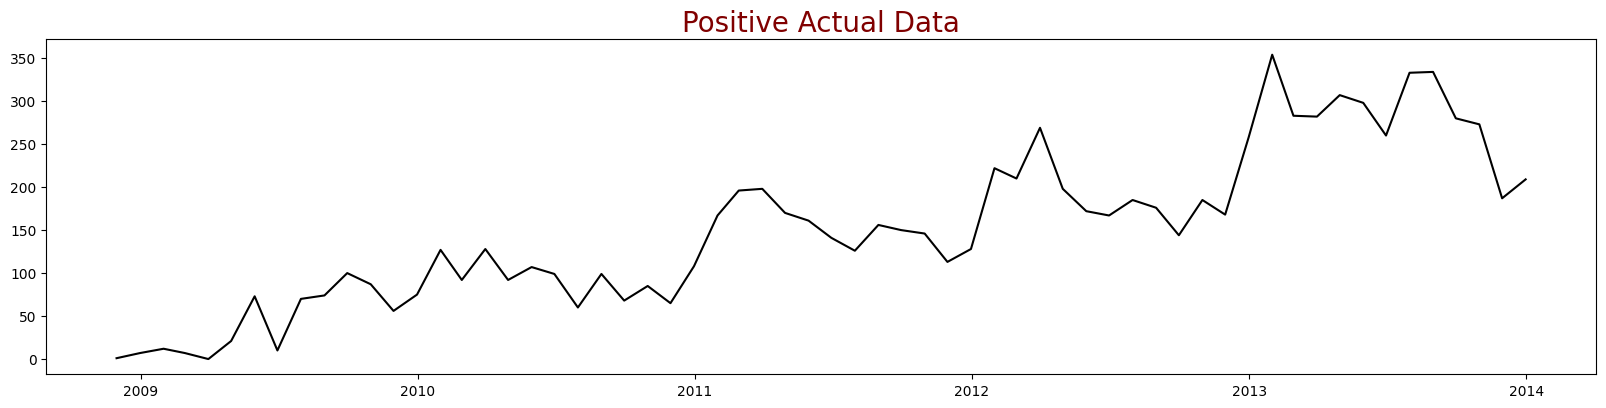

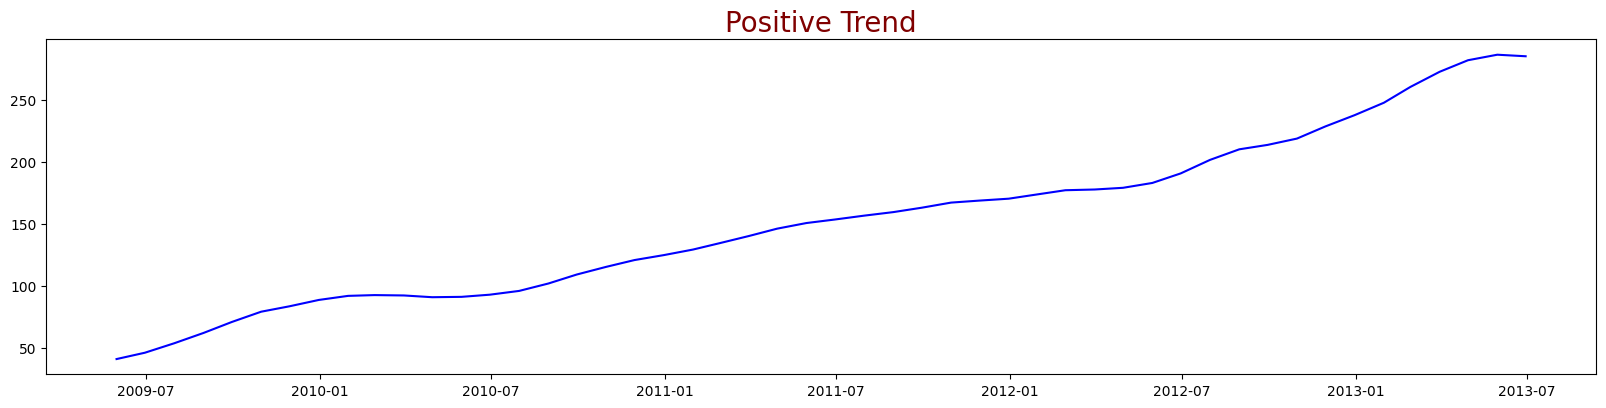

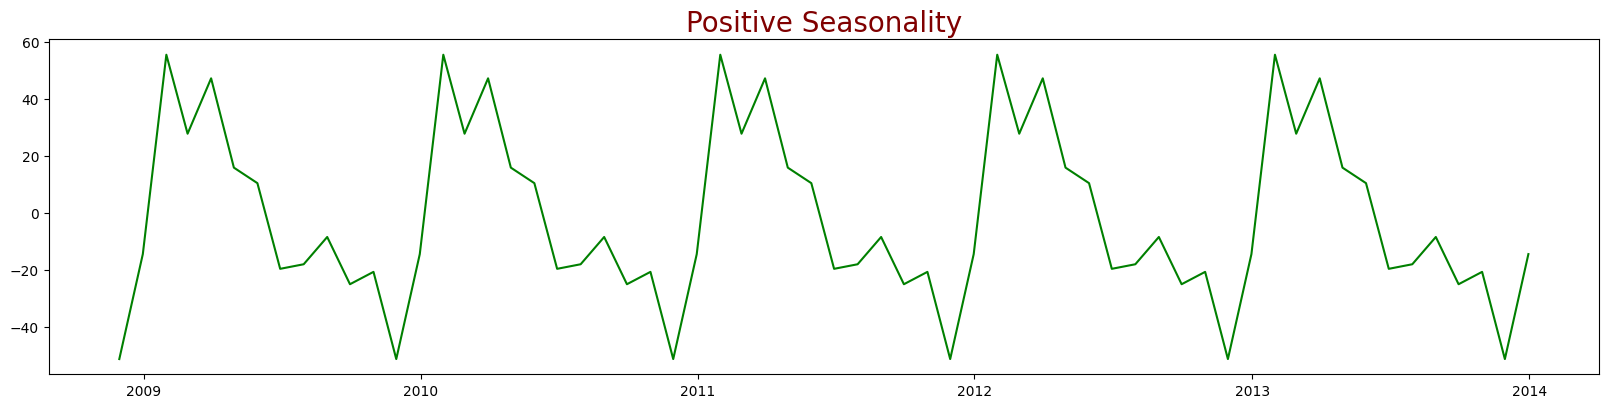

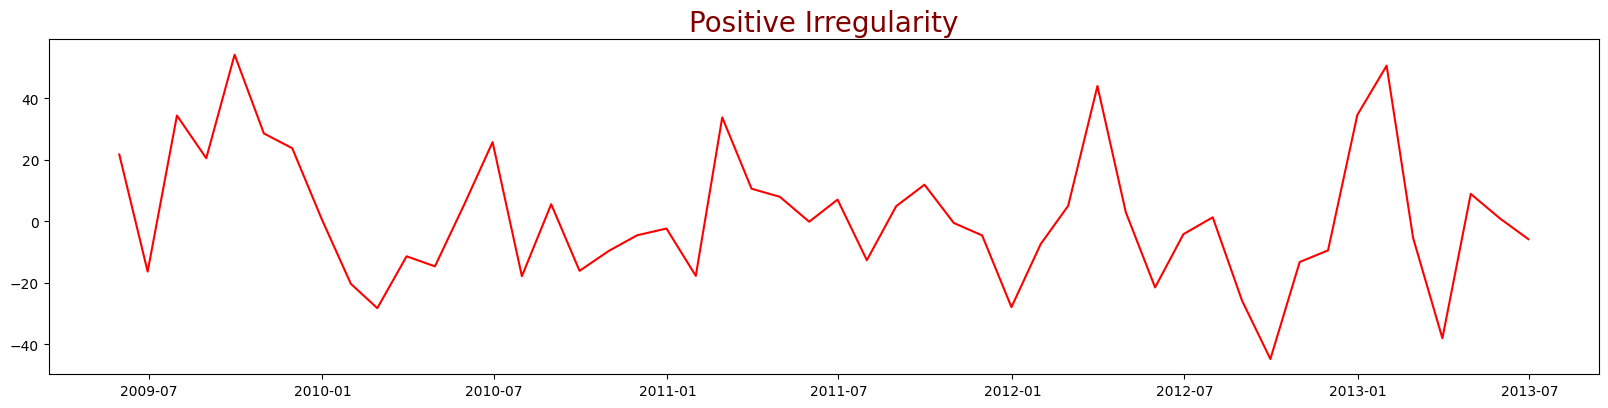

In [36]:
# Positive Time Series Data Components
trend, season, irreg = time_series_comp(res_data)

plot_comp(res_data,trend,season,irreg,'Positive')
plt.show();

In [37]:
# Stationary Check
stationarity_check(res_data)

'Model was not Stationary - Take Differenced Data'

In [38]:
# Differencing Data
res_data_diff = res_data - res_data.shift(1)
res_data_diff.dropna(inplace=True)

In [39]:
# Stationary Check
stationarity_check(res_data_diff)

'Model was Stationary - Proceed for Model Building'

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

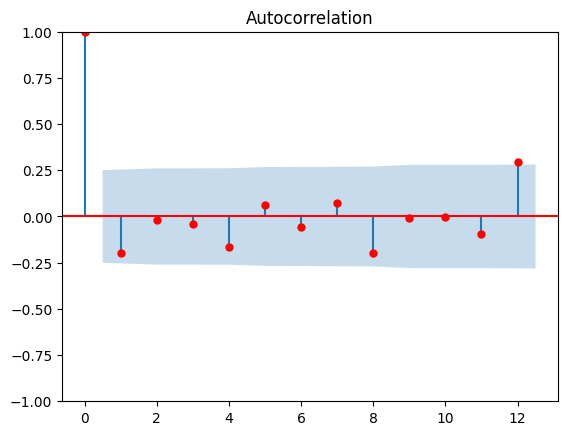

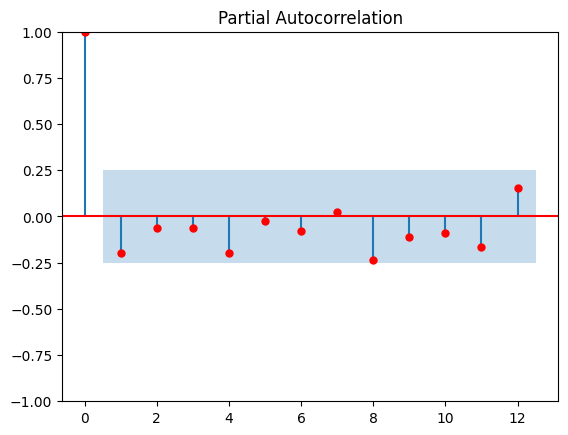

In [40]:
# Plotting ACF and PACF
plot(res_data_diff)

In [41]:
# Splitting Data
sep = int(res_data.shape[0]*0.8)

train = res_data[:sep+1]
test = res_data[sep:]

In [42]:
# Model Building
model_1 = sm.tsa.statespace.SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12)).fit()

In [43]:
# Fit Check
fit_check(model_1)

Good model - Proceed for Forecasting


In [44]:
# Forecasting the Data
pred = model_1.forecast(len(test)+30)

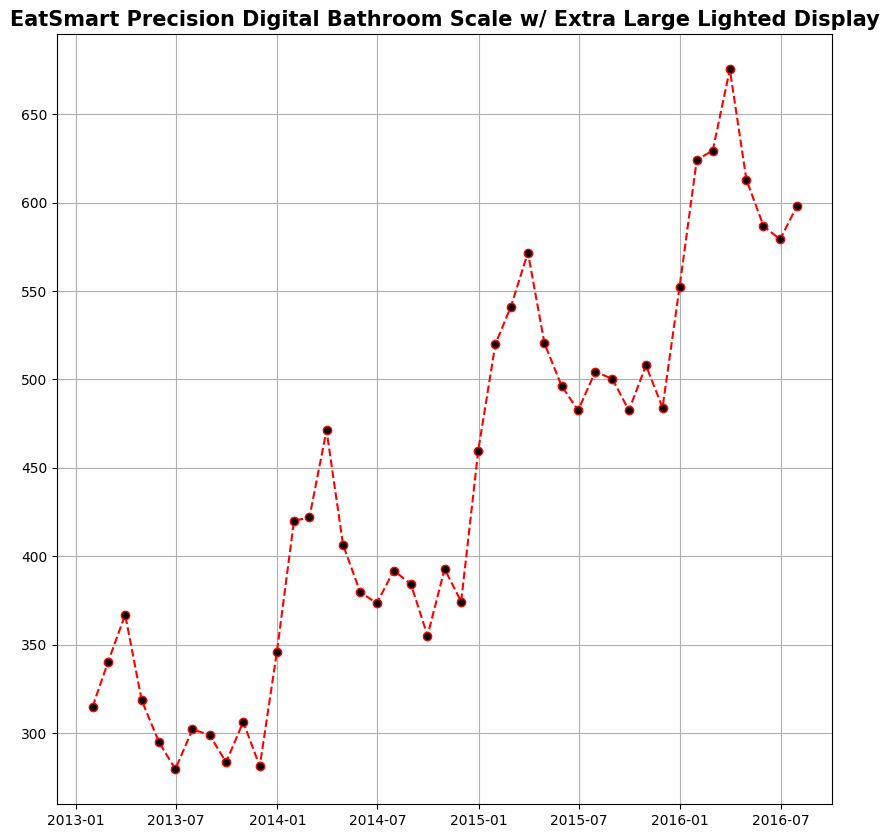

In [45]:
# Plotting Data
plt.figure(figsize=(10,10))
plt.plot(pred,ls='--',marker='o',mfc='black',color='red')
plt.title('EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display',fontsize=15,fontweight = 'bold')
plt.grid()
plt.show();

## Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform and Step-on Technology, 440-Pounds

In [46]:
# Products which are sold more
data.title.value_counts()

EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display, 400 lb. Capacity and &quot;Step-On&quot; Technology [2014 VERSION] - 10,000+ Reviews EatSmart Guaranteed Accurate    9329
Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform and Step-on Technology, 440-Pounds                                                                                     7604
Fitbit One Wireless Activity Plus Sleep Tracker, Black                                                                                                                                         4537
BlenderBottle&reg; Classic 20-ounce Green                                                                                                                                                      3982
Crane Drop Shape Ultrasonic Cool Mist Humidifier with 2.3 Gallon output per day                                                                                                                3664
                    

In [47]:
# Data Filtering
data_2 = data.loc[data.title == 'Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform and Step-on Technology, 440-Pounds','title']

In [48]:
# Resampling the Data
res_data = data_2.resample('M').count()

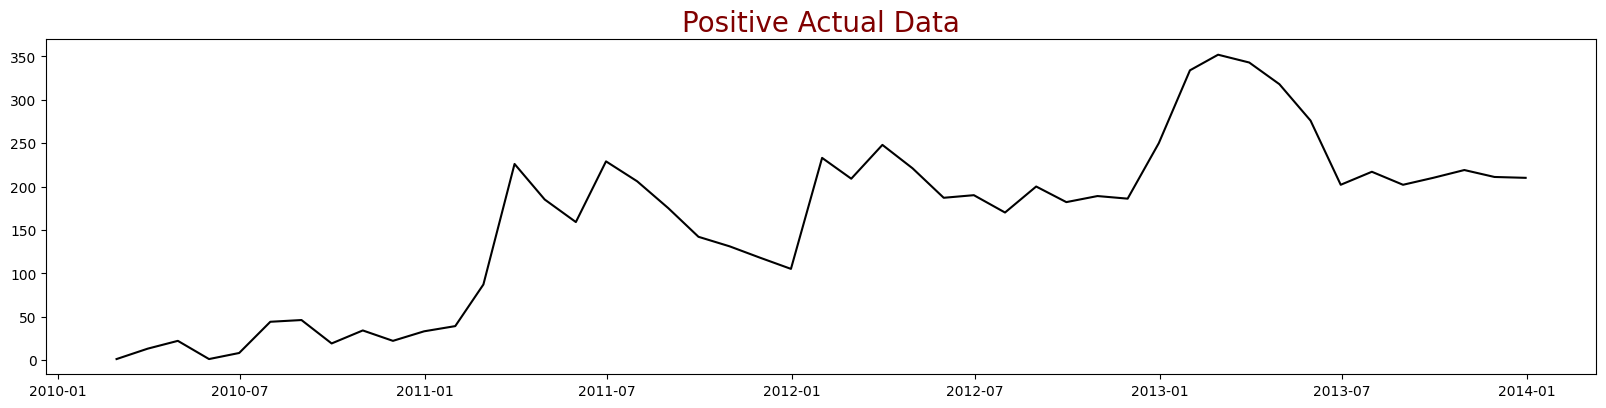

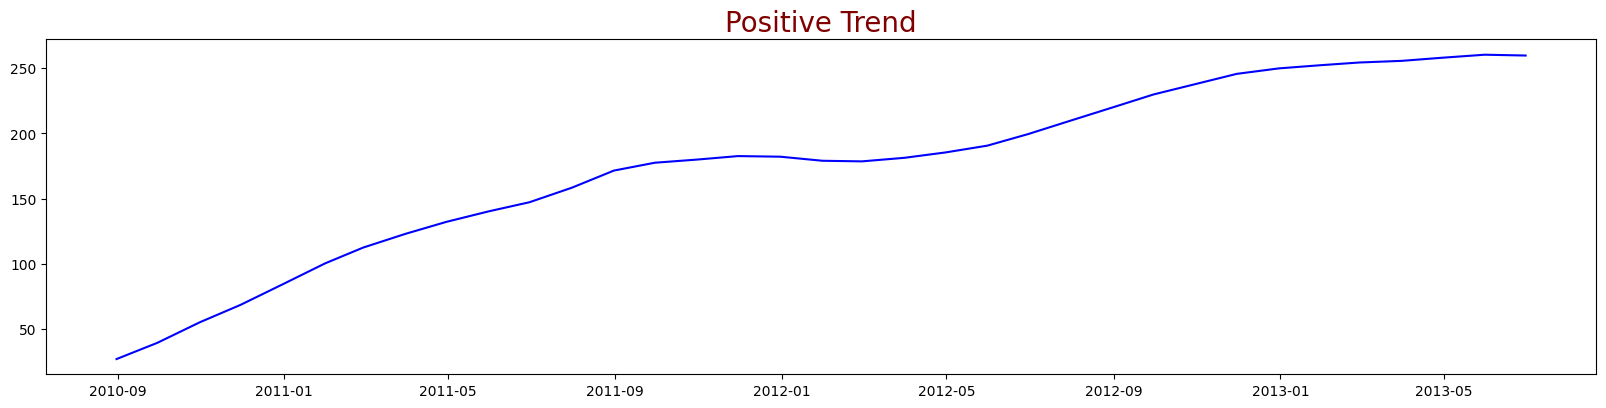

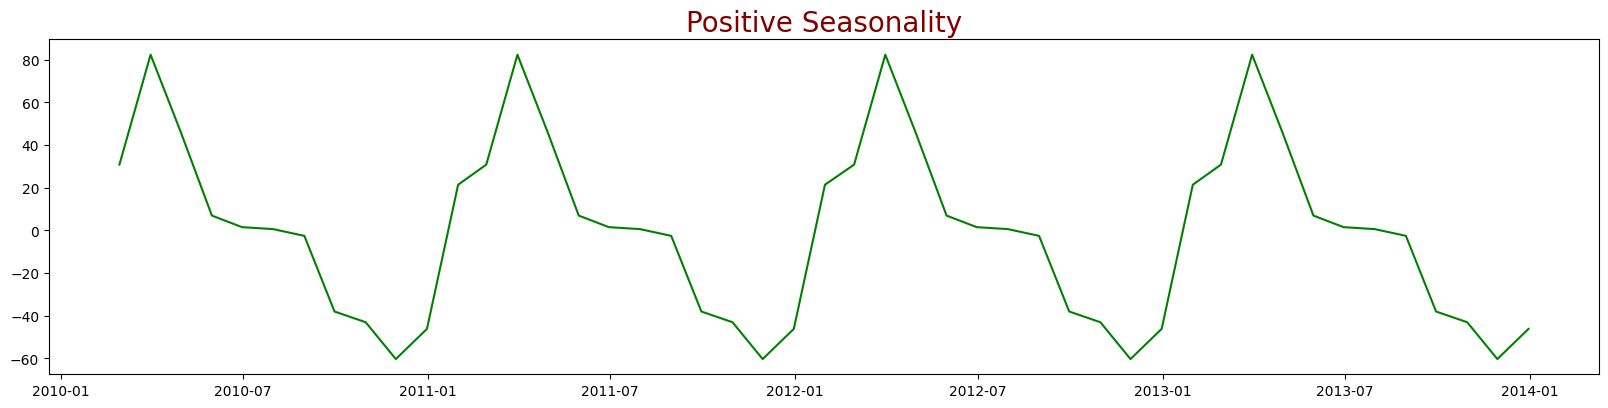

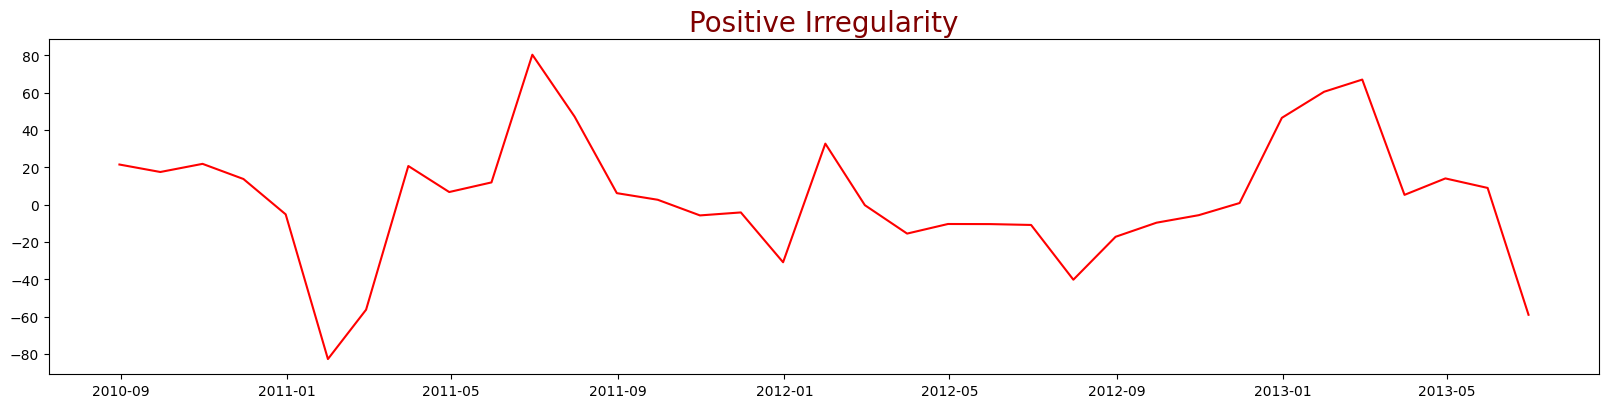

In [49]:
# Positive Time Series Data Components
trend, season, irreg = time_series_comp(res_data)

plot_comp(res_data,trend,season,irreg,'Positive')
plt.show();

In [50]:
# Stationary Check
stationarity_check(res_data)

'Model was not Stationary - Take Differenced Data'

In [51]:
# Differencing Data
res_data_diff = res_data - res_data.shift(1)
res_data_diff.dropna(inplace=True)

In [52]:
# Stationary Check
stationarity_check(res_data_diff)

'Model was Stationary - Proceed for Model Building'

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

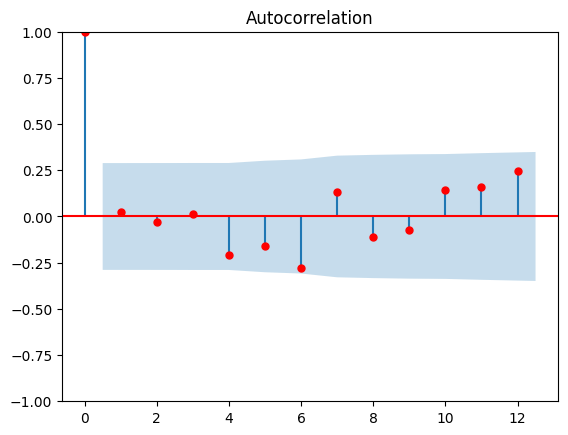

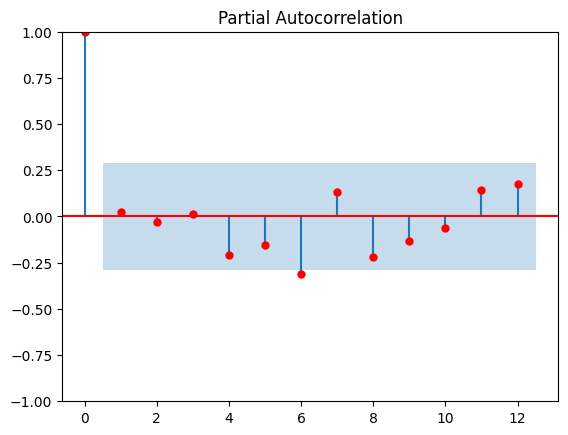

In [53]:
# Plotting ACF and PACF
plot(res_data_diff)

In [54]:
# Splitting Data
sep = int(res_data.shape[0]*0.8)

train = res_data[:sep+1]
test = res_data[sep:]

In [55]:
# Model Building
model_2 = sm.tsa.statespace.SARIMAX(train,order=(1,1,0),seasonal_order=(1,1,0,12)).fit()

In [56]:
# Fit Check
fit_check(model_2)

Good model - Proceed for Forecasting


In [57]:
# Forecasting the Data
pred = model_2.forecast(len(test)+30)

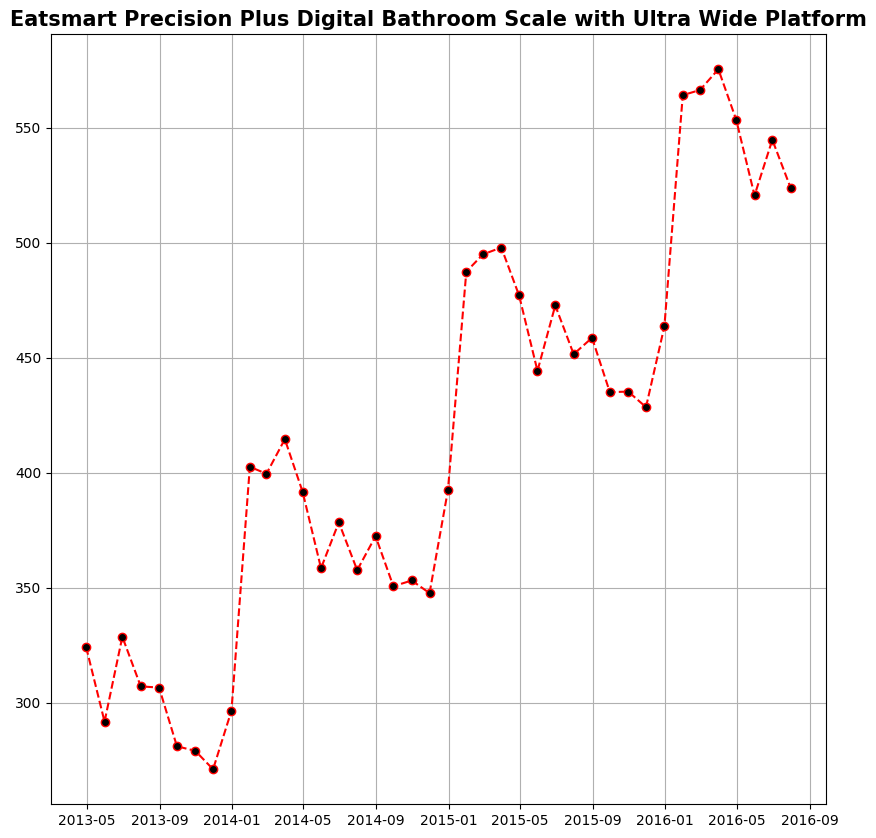

In [58]:
# Plotting Data
plt.figure(figsize=(10,10))
plt.plot(pred,ls='--',marker='o',mfc='black',color='red')
plt.title('Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform',fontsize=15,fontweight = 'bold')
plt.grid()
plt.show();